In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import time
import os
from PIL import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import zipfile
import os
from google.colab import files


import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [2]:
# Upload dataset from local machine
uploaded = files.upload()

# Extract the uploaded zip file
zip_file = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('dataset')

# Verify extraction
os.listdir('dataset')


Saving train_ASD_DATA.zip to train_ASD_DATA.zip


['train_ASD_DATA']

In [3]:
# Upload dataset from local machine
uploaded = files.upload()

# Extract the uploaded zip file
zip_file = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('dataset')

# Verify extraction
os.listdir('dataset')


Saving test_ASD_DATA.zip to test_ASD_DATA.zip


['train_ASD_DATA', 'test']

In [4]:




# Upload dataset from local machine
uploaded = files.upload()

# Extract the uploaded zip file
zip_file = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('dataset')

# Verify extraction
os.listdir('dataset')


Saving valid_ASD_DATA.zip to valid_ASD_DATA.zip


['valid', 'train_ASD_DATA', 'test']

Fetching directories in variables train_dsr,validation_dir,test_dir



In [5]:
train_asd_dir = '/content/dataset/train_ASD_DATA/train/Autistic'
train_nasd_dir ='/content/dataset/train_ASD_DATA/train/Non_Autistic'
validation_asd_dir ='/content/dataset/valid/Autistic'
validation_nasd_dir ='/content/dataset/valid/Non_Autistic'
test_asd_dir = '/content/dataset/test/Autistic'
test_nasd_dir = '/content/dataset/test/Non_Autistic'

Showing some fetched data



In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_asd_fnames = os.listdir( train_asd_dir )
train_nasd_fnames = os.listdir( train_nasd_dir )


next_asd_pix = [os.path.join(train_asd_dir, fname)
                for fname in train_asd_fnames[ pic_index-8:pic_index]
               ]

next_nasd_pix = [os.path.join(train_nasd_dir, fname)
                for fname in train_nasd_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_asd_pix+next_nasd_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

Data Augmentation to make more photos



In [ ]:
train_asd_dir = '/content/dataset/train_ASD_DATA/train/Autistic'
train_nasd_dir ='/content/dataset/train_ASD_DATA/train/Non_Autistic'
validation_asd_dir ='/content/dataset/valid/Autistic'
validation_nasd_dir ='/content/dataset/valid/Non_Autistic'
test_asd_dir = '/content/dataset/test/Autistic'
test_nasd_dir = '/content/dataset/test/Non_Autistic'

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

#Training Set
train_set = train_datagen.flow_from_directory('/content/dataset/train_ASD_DATA/train',
                                             target_size=(299,299),
                                             batch_size=10,
                                             class_mode='binary')
#Validation Set
valid_set = valid_datagen.flow_from_directory('/content/dataset/valid',
                                           target_size=(299,299),
                                           batch_size = 10,
                                           class_mode='binary',
                                           shuffle=False)
#Test Set
test_set = test_datagen.flow_from_directory('/content/dataset/test',
                                            target_size=(299,299),
                                            batch_size = 10,
                                            class_mode='binary',
                                            shuffle=False)

Found 2526 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


Pretrained Inception Model Importing



In [16]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (299, 299, 3), include_top = False, weights = 'imagenet')


Basic Inception Weight Not updated



In [17]:

#To set the layers to non-trainable (weights will not be updated)
for layer in base_model.layers:
    layer.trainable = False

Last layer changed as per below



In [18]:
from tensorflow.keras import layers
import tensorflow as tf

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

#RMS optimizer
#model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

from tensorflow.keras import optimizers

# Define the learning rate
learning_rate = 0.0001

# Compile the model with the Adam optimizer and learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['acc'])


In [19]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalization_94

model.summary()


In [ ]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from keras.callbacks import ModelCheckpoint, EarlyStopping
import time
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the InceptionV3 model
base_model = InceptionV3(input_shape=(299, 299, 3), weights='imagenet', include_top=False)
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])

model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Measure the training time
start_time = time.time()

# Train the model with data augmentation
inc_best = model.fit(train_set, validation_data=valid_set, epochs=100, verbose=1, callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='/content/dataset/Model/inception_imagenet_adam.keras', save_best_only=True, monitor='val_loss', verbose=1)
])

end_time = time.time()
training_time = end_time - start_time

print(f"Training time: {training_time} seconds")

Epoch 1/100
253/253 [==============================] - ETA: 0s - loss: 0.5813 - accuracy: 0.7031
Epoch 1: val_loss improved from inf to 0.40743, saving model to /content/dataset/Model/inception_imagenet_adam.keras
253/253 [==============================] - 41s 104ms/step - loss: 0.5813 - accuracy: 0.7031 - val_loss: 0.4074 - val_accuracy: 0.8625
Epoch 2/100
253/253 [==============================] - ETA: 0s - loss: 0.4395 - accuracy: 0.7910
Epoch 2: val_loss improved from 0.40743 to 0.34826, saving model to /content/dataset/Model/inception_imagenet_adam.keras
253/253 [==============================] - 25s 99ms/step - loss: 0.4395 - accuracy: 0.7910 - val_loss: 0.3483 - val_accuracy: 0.8375
Epoch 3/100
253/253 [==============================] - ETA: 0s - loss: 0.3813 - accuracy: 0.8278
Epoch 3: val_loss improved from 0.34826 to 0.24225, saving model to /content/dataset/Model/inception_imagenet_adam.keras
253/253 [==============================] - 25s 99ms/step - loss: 0.3813 - accuracy:

In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import time

# Record the start time
start_time = time.time()

inc_best = model.fit(
    train_set,
    validation_data=valid_set,
    steps_per_epoch=158,
    epochs=100,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10),
        ModelCheckpoint(filepath='/content/gdrive/MyDrive/DNN Keras Models/inception_imagenet_adam.h5', save_best_only=True)
    ]
)

# Calculate the training time
end_time = time.time()
training_time = end_time - start_time

# Convert training time to hours, minutes, and seconds
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Training completed in: {int(hours):0>2}:{int(minutes):0>2}:{seconds:05.2f}")
print(f"Total training time in seconds: {training_time:.2f}")

# To discover the training epoch on which training was stopped
final_epoch = len(inc_best.history['loss'])
print(f"Training stopped at epoch: {final_epoch}")

Epoch 1/100
158/158 [==============================] - 43s 270ms/step - loss: 0.5254 - acc: 0.7513 - val_loss: 0.3370 - val_acc: 0.9000
Epoch 2/100
158/158 [==============================] - 48s 302ms/step - loss: 0.4751 - acc: 0.7665 - val_loss: 0.2927 - val_acc: 0.8875
Epoch 3/100
158/158 [==============================] - 40s 255ms/step - loss: 0.4635 - acc: 0.7862 - val_loss: 0.2835 - val_acc: 0.9000
Epoch 4/100
158/158 [==============================] - 36s 228ms/step - loss: 0.4247 - acc: 0.8051 - val_loss: 0.3138 - val_acc: 0.8750
Epoch 5/100
158/158 [==============================] - 48s 305ms/step - loss: 0.4387 - acc: 0.8109 - val_loss: 0.2675 - val_acc: 0.8875
Epoch 6/100
158/158 [==============================] - 35s 223ms/step - loss: 0.4133 - acc: 0.8077 - val_loss: 0.2717 - val_acc: 0.8875
Epoch 7/100
158/158 [==============================] - 36s 225ms/step - loss: 0.3915 - acc: 0.8158 - val_loss: 0.3711 - val_acc: 0.8125
Epoch 8/100
158/158 [===========================

In [22]:
model.save('/content/dataset/Model/inception_best.h5')


In [23]:
#model for plotting
inception = model.fit(train_set, validation_data = valid_set, steps_per_epoch = 100, epochs = 100)

Epoch 1/100
100/100 [==============================] - 23s 232ms/step - loss: 0.2163 - acc: 0.9116 - val_loss: 0.2308 - val_acc: 0.9125
Epoch 2/100
100/100 [==============================] - 22s 222ms/step - loss: 0.2139 - acc: 0.9160 - val_loss: 0.2519 - val_acc: 0.9125
Epoch 3/100
100/100 [==============================] - 23s 229ms/step - loss: 0.2143 - acc: 0.9086 - val_loss: 0.2122 - val_acc: 0.9125
Epoch 4/100
100/100 [==============================] - 24s 235ms/step - loss: 0.1839 - acc: 0.9290 - val_loss: 0.1728 - val_acc: 0.9375
Epoch 5/100
100/100 [==============================] - 23s 230ms/step - loss: 0.1936 - acc: 0.9210 - val_loss: 0.2355 - val_acc: 0.9250
Epoch 6/100
100/100 [==============================] - 23s 226ms/step - loss: 0.2088 - acc: 0.9030 - val_loss: 0.1761 - val_acc: 0.9500
Epoch 7/100
100/100 [==============================] - 23s 228ms/step - loss: 0.1859 - acc: 0.9210 - val_loss: 0.1498 - val_acc: 0.9375
Epoch 8/100
100/100 [===========================

In [ ]:
model.save('/content/dataset/Model/inception_100.h5')


Model Loss Plotting



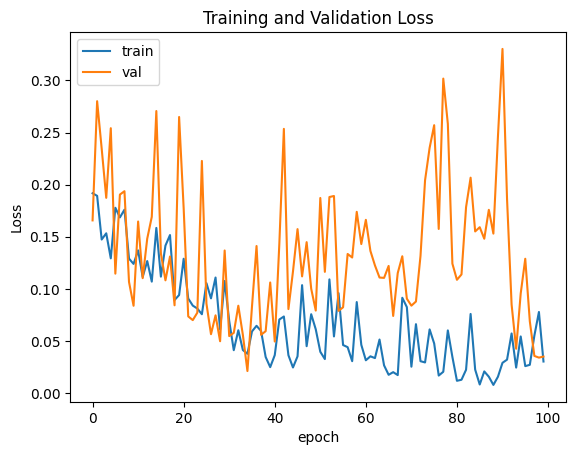

In [ ]:

import keras
from matplotlib import pyplot as plt


plt.plot(inception.history['loss'])
plt.plot(inception.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model Accuracy Plotting



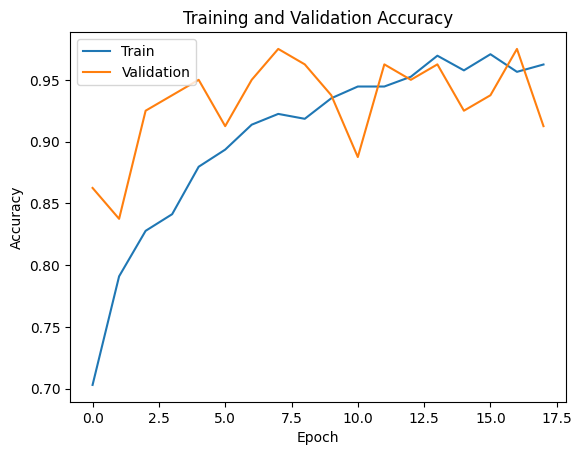

In [ ]:
import matplotlib.pyplot as plt

# Assuming `inc_best` is the history object returned by `model.fit`
history = inc_best.history

# Plot training & validation accuracy values
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:

import keras
from matplotlib import pyplot as plt


plt.plot(inception.history['acc'])
plt.plot(inception.history['val_acc'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

KeyError: 'acc'

Prediction of an Image of Test Set



In [ ]:

from tensorflow.keras.models import load_model
model = load_model('/content/dataset/Model/inception_100.h5')

1/1 [==============================] - 4s 4s/step


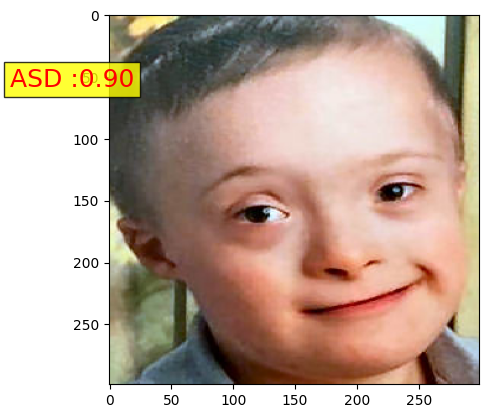

In [ ]:

#Prediction of image
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img1 = image.load_img('/content/dataset/test/Autistic/ta.014.jpg', target_size=(299, 299))
img = image.img_to_array(img1)
img = img/255
# create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0)
prediction = model.predict(img, batch_size=None,steps=1) #gives all class prob.
if(prediction[:,:]>0.5):
    value ='NASD :%1.2f'%(prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='yellow',alpha=0.8))
else:
    value ='ASD :%1.2f'%(1.0-prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,horizontalalignment='right',
        verticalalignment='bottom',bbox=dict(facecolor='yellow',alpha=0.8))

plt.imshow(img1)
plt.show()

1/1 [==============================] - 0s 66ms/step


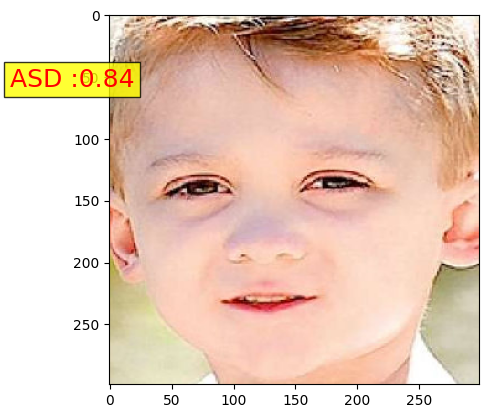

In [ ]:

#Prediction of image
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img1 = image.load_img('/content/dataset/test/Non_Autistic/tna.005.jpg', target_size=(299, 299))
img = image.img_to_array(img1)
img = img/255
# create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0)
prediction = model.predict(img, batch_size=None,steps=1) #gives all class prob.
if(prediction[:,:]>0.5):
    value ='NASD :%1.2f'%(prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='yellow',alpha=0.8))
else:
    value ='ASD :%1.2f'%(1.0-prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,horizontalalignment='right',
        verticalalignment='bottom',bbox=dict(facecolor='yellow',alpha=0.8))

plt.imshow(img1)
plt.show()

Confusion Matrix of Test Set



Precision, Recall, F1 score, inference time

In [ ]:
import pandas as pd
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Reset the test set (if needed)
test_set.reset()

# Measure inference time
start_inference_time = time.time()
ytesthat = model.predict_generator(test_set)
end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time

print(f"Inference time: {inference_time} seconds")

# Create a DataFrame to store the results
df = pd.DataFrame({
    'filename': test_set.filenames,
    'predict': ytesthat[:, 0],
    'y': test_set.classes
})

# Convert the predicted probabilities to binary predictions
y_pred_binary = (ytesthat > 0.5).astype(int)

# Get the true labels from the test set
y_true = test_set.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_binary)

# Calculate precision
precision = precision_score(y_true, y_pred_binary)

# Calculate recall
recall = recall_score(y_true, y_pred_binary)

# Calculate F1 score
f1 = f1_score(y_true, y_pred_binary)

# Print the metrics
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


<ipython-input-26-f4f588b33b4c>:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  ytesthat = model.predict_generator(test_set)


Inference time: 1.9858133792877197 seconds
Test Accuracy: 0.9535714285714286
Precision: 1.0
Recall: 0.9071428571428571
F1 Score: 0.9513108614232211


In [ ]:
import pandas as pd
test_set.reset
ytesthat = model.predict_generator(test_set)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert the predicted probabilities to binary predictions
y_pred_binary = (ytesthat > 0.5).astype(int)

# Get the true labels from the test set
y_true = test_set.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_binary)

# Calculate precision
precision = precision_score(y_true, y_pred_binary)

# Calculate recall
recall = recall_score(y_true, y_pred_binary)

# Calculate F1 score
f1 = f1_score(y_true, y_pred_binary)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)




df = pd.DataFrame({
    'filename':test_set.filenames,
    'predict':ytesthat[:,0],
    'y':test_set.classes
})


<ipython-input-25-000144cbfeae>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  ytesthat = model.predict_generator(test_set)


Accuracy: 0.925
Precision: 0.9343065693430657
Recall: 0.9142857142857143
F1 Score: 0.9241877256317689


In [ ]:

pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict']>0.5
df.y_pred = df.y_pred.astype(int)

In [ ]:

misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from 280 Testing images : %d'%misclassified['y'].count())


Total misclassified image from 280 Testing images : 21


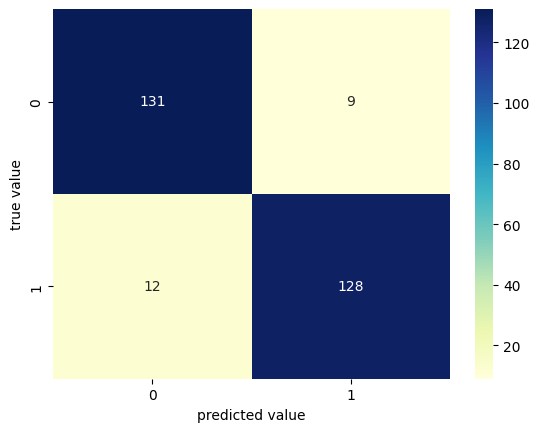

In [ ]:
#Prediction of test set
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

Confusion Matrix of Train Set



In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

#Training Set
train_set = train_datagen.flow_from_directory('/content/dataset/train_ASD_DATA/train',
                                             target_size=(150,150),
                                             batch_size=10,
                                              shuffle=False,
                                             class_mode='binary')

Found 2526 images belonging to 2 classes.


In [ ]:

import pandas as pd
train_set.reset
ytrainhat = model.predict_generator(train_set)
df = pd.DataFrame({
    'filename':train_set.filenames,
    'predict':ytrainhat[:,0],
    'y':train_set.classes
})

<ipython-input-31-86d4ed593533>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  ytrainhat = model.predict_generator(train_set)


In [ ]:

pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict']>0.5
df.y_pred = df.y_pred.astype(int)

In [ ]:

misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from 2526 Training images : %d'%misclassified['y'].count())

Total misclassified image from 2526 Training images : 100


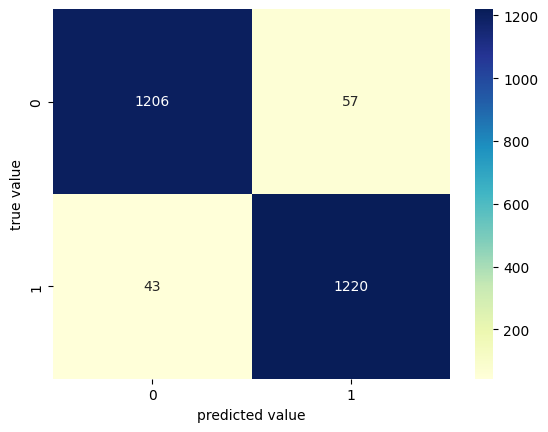

In [ ]:

#Prediction of test set
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

Confusion Matrix of Validation Set



In [ ]:

import pandas as pd
valid_set.reset
yvalidhat = model.predict_generator(valid_set)
df = pd.DataFrame({
    'filename':valid_set.filenames,
    'predict':yvalidhat[:,0],
    'y':valid_set.classes
})


<ipython-input-35-bd2cf0d3b7bc>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  yvalidhat = model.predict_generator(valid_set)


In [ ]:

pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict']>0.5
df.y_pred = df.y_pred.astype(int)

In [ ]:
misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from 80 Validation images : %d'%misclassified['y'].count())

Total misclassified image from 80 Validation images : 3


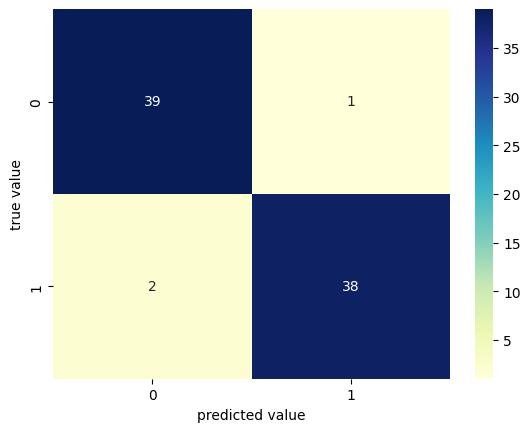

In [ ]:

#Prediction of test set
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');